# Notebook to create ROC plots & Figure 8

In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn import metrics
import random
from dataprep import *
import anndata as ad
import pickle
import seaborn as sns

In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)


custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")
colorblind_palette = sns.color_palette("colorblind")
# Like colorblind_palette[4] for control, colorblind_palette[0] for test

## Loading RF Models & Datasets

In [18]:
# balanced pattern/nonpattern RF based on mixed ID embeddings.
path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_balanced_mixedID.pkl"
with open(path, 'rb') as p:
    rf_classifier_balanced_mixed = pickle.load(p)

# balanced pattern/nonpattern RF based on splt ID embeddings.
path1 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_balanced_splitID.pkl"
with open(path1, 'rb') as p:
    rf_classifier_balanced_split = pickle.load(p)

# Pericellular Balanced training included nonpatterned cells
path2 = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pericellular_balanced_inclRandom.pkl"
with open(path2, 'rb') as p:
    rf_balanced_inclRandom = pickle.load(p)

# Pericellular Balanced training excluded nonpatterned cells
path2 = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_pericellular/rf_balanced.pkl"
with open(path2, 'rb') as p:
    rf_balanced_exclRandom = pickle.load(p)

In [17]:
# balanced RF based on splt ID embeddings with cell2 conda environment --> newer scikit-learn version so that I can include the chance level in the plots.
path1 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pericellular_balanced_cell2.pkl"
with open(path1, 'rb') as p:
    rf_pericellular = pickle.load(p)

In [3]:
# balanced RF based on splt ID embeddings with cell2 conda environment --> newer scikit-learn version so that I can include the chance level in the plots.
path1 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_pattern_nonpattern_balanced_cell2.pkl"
with open(path1, 'rb') as p:
    rf_classifier_balanced = pickle.load(p)

In [4]:
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
#adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [5]:
adata_split_cellID = initialize_adata(adata_split_cellID)
#adata_mixed_cellID = initialize_adata(adata_mixed_cellID)

# Pericellular RF

/tmp/ipykernel_166225/1617139924.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_allstrengths.obs['pericellular'] = np.where(adata_test_allstrengths.obs["pattern"] == 'pericellular', 'pericellular', "other")


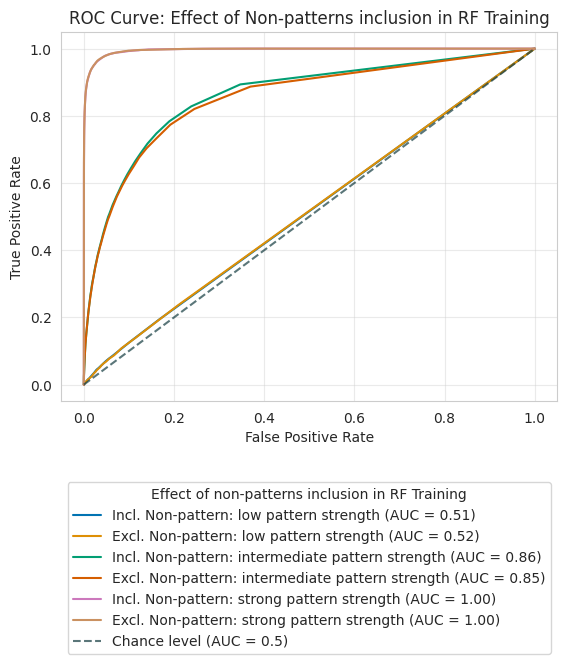

In [28]:
adata_test_allstrengths = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]
adata_test_allstrengths.obs['pericellular'] = np.where(adata_test_allstrengths.obs["pattern"] == 'pericellular', 'pericellular', "other")
pattern_strength = ["low", "intermediate", "strong"]
# 'unbalanced': rf_peri_unbalanced, 'balanced': rf_peri_balanced, 'unbalanced_inclRandom': rf_peri_balanced_inclRandom
models= {"Incl. Non-pattern: ": rf_balanced_inclRandom,"Excl. Non-pattern: ": rf_balanced_exclRandom}
predictions = {}

fig, ax = plt.subplots()

for strength in pattern_strength:
    for name, model in models.items():
        adata_test_strength = adata_test_allstrengths[adata_test_allstrengths.obs["pattern_strength"]==strength]
        test_pred = model.predict_proba(adata_test_strength.obsm["latent"])[:,1]
        predictions[name] = RocCurveDisplay.from_predictions(
            adata_test_strength.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = f"{name}{strength} pattern strength",
            ax=ax,
            plot_chance_level=True if ((strength == 'strong')&(model==rf_balanced_exclRandom)) else False,
            chance_level_kw={'color': '#143C40', 'alpha': 0.7})
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve: Effect of Non-patterns inclusion in RF Training"
    )
plt.legend(title="Effect of non-patterns inclusion in RF Training", bbox_to_anchor=(0, -0.4, 1,0.2), loc="upper center")
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

In [39]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]
adata_test.obs['pericellular'] = np.where(adata_test.obs["pattern"] == 'pericellular', 'pericellular', "other")

adatas_inclRandom = {}
adatas_exclRandom = {}
for strength in ['low', 'intermediate', 'strong']:
    adata_strength = adata_test[adata_test.obs['pattern_strength']==strength]
    adatas_inclRandom[strength] = balanceTrainingData(adata_strength, testPattern = 'pericellular', include_random = True, random_seed = seed)
    adatas_exclRandom[strength] = balanceTrainingData(adata_strength, testPattern = 'pericellular', include_random = False, random_seed = seed)

/tmp/ipykernel_166225/3099283680.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['rna_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)
/media/gambino/students_workdir/nynke/blurry/dataprep.py:274: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pattern_groups = adata_control.obs.groupby('pattern')
/media/gambino/students_workdir/nynke/blurry/dataprep.py:274: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pattern_groups = adata_control.obs.groupby('pattern')
/media/gambino/students_workdir/nynke/blurry/dataprep.py:274: Fut

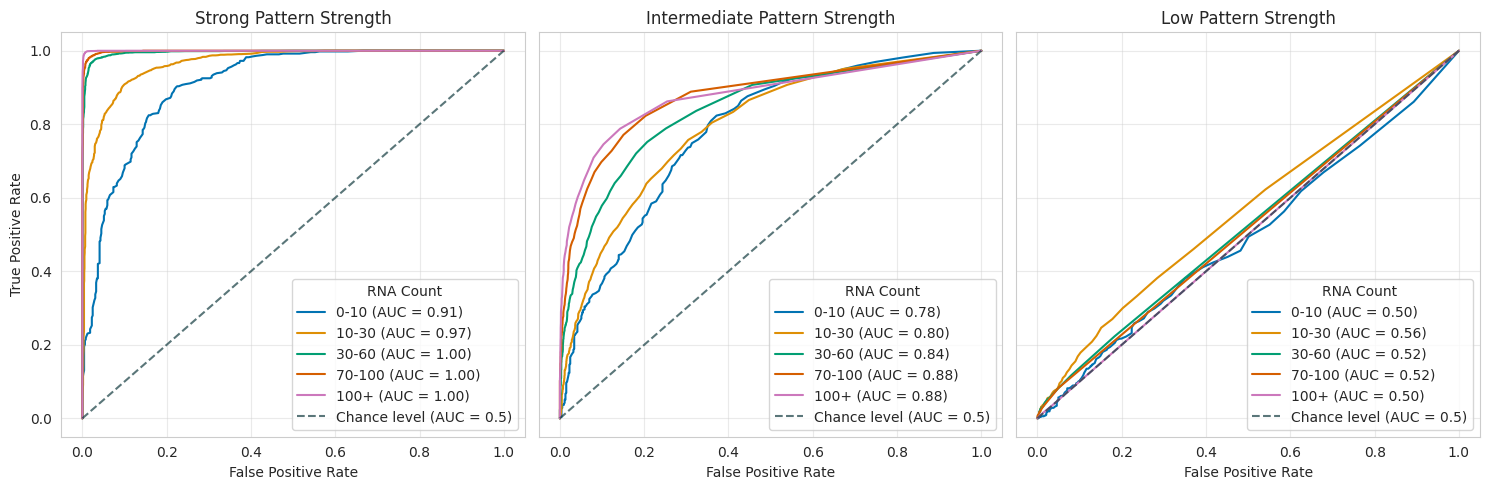

In [46]:
intervals = ['0-10','10-30','30-60', '70-100','100+']
predictions = {}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, strength in enumerate(['strong', 'intermediate', 'low']):
    ax = axs[i]  # Select the subplot for the current strength
    adata_strength = adatas_exclRandom[strength]
    for interval in intervals:
        adata_counts = adata_strength[adata_strength.obs['rna_count']==interval]
        test_pred = rf_balanced_inclRandom.predict_proba(adata_counts.obsm["latent"])[:,1]
        predictions[interval] = RocCurveDisplay.from_predictions(
            adata_counts.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = interval,
            ax=ax,
            plot_chance_level=True if interval == '100+' else False,
            chance_level_kw={'color': '#143C40', 'alpha': 0.7})
    ax.set(
        xlabel = "False Positive Rate",
        title = f"{strength.capitalize()} Pattern Strength")
    if i != 0:  # Remove the x-label for the non-left plots
        ax.set(ylabel="")
        ax.set_yticklabels([])
    else:  # Set the x-label for the left-most plot
        ax.set(ylabel = "True Positive Rate")
    #ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), label='Chance Level')  # Plot the chance level line
    
    ax.legend(title="RNA Count", loc='lower right')



plt.tight_layout(w_pad=1)
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

# Pattern / No pattern RF

## Generating the Histograms in figure 8

This code snippet creates a dataframe with the RF classification probabilities of the different models for the different datasets. 

Predict_proba returns a nx2 array, where the two columns are the probabilities for [nonpattern, pattern], hence the [:,1]

#### Pattern versus nonpattern graphs

In [31]:
rows = []

adata_test_split = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]
adata_test_mixed = adata_mixed_cellID[adata_mixed_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

split_pattern = adata_test_split[(adata_test_split.obs['random_or_pattern']=='pattern')]
split_no_pattern = adata_test_split[adata_test_split.obs['random_or_pattern']=='nonpattern']
mixed_pattern = adata_test_mixed[adata_test_mixed.obs['random_or_pattern']=='pattern']
mixed_no_pattern = adata_test_mixed[adata_test_mixed.obs['random_or_pattern']=='nonpattern']

for model in [rf_classifier_balanced_split, rf_classifier_balanced_mixed]:
    split_patterned = model.predict_proba(split_pattern.obsm["latent"])[:,1]
    split_nopatterned = model.predict_proba(split_no_pattern.obsm["latent"])[:,1]
    mixed_patterned = model.predict_proba(mixed_pattern.obsm["latent"])[:,1]
    mixed_nopatterned = model.predict_proba(mixed_no_pattern.obsm["latent"])[:,1]
    for value in split_patterned:
        rows.append({'prob_pattern': value, 'model':model, 'group': 'split_pattern'})
    for value in split_nopatterned:
        rows.append({'prob_pattern': value, 'model':model, 'group': 'split_no_pattern'})
    for value in mixed_patterned:
        rows.append({'prob_pattern': value, 'model':model, 'group': 'mixed_pattern'})
    for value in mixed_nopatterned:
        rows.append({'prob_pattern': value, 'model':model, 'group': 'mixed_no_pattern'})
df = pd.DataFrame(rows)

/media/gambino/students_workdir/nynke/blurry/images/embedding_pictures/splitData_splitRF.png

201
201


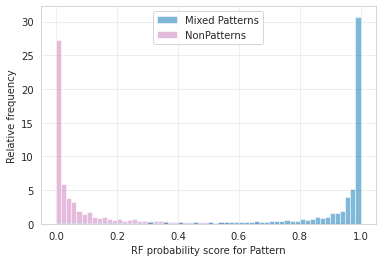

In [93]:
pattern = ['split_pattern','mixed_pattern']
nonpattern = ['split_no_pattern','mixed_no_pattern']
# rf pattern balanced is the model I used to generate the figures in April
models = [rf_classifier_balanced_split, rf_classifier_balanced_mixed]
model = ['Split Embedding', 'Mixed Embedding']

test = df[(df['group']==pattern[0])&(df['model']==models[0])]
control = df[(df['group']==nonpattern[0])&(df['model']==models[0])]

print(len(control['prob_pattern'].unique()))
print(len(test['prob_pattern'].unique()))


plt.hist(control['prob_pattern'], bins=60, alpha=0.5, label='NonPatterns', density=True, color=colorblind_palette[4])
plt.hist(test['prob_pattern'], bins=60, alpha=0.5, label='Mixed Patterns', density=True, color=colorblind_palette[0])


# Get the handles and labels from the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Sort them together based on the labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# Set the legend again with the sorted handles and labels
plt.legend(handles, labels, loc='upper center')

plt.xlabel("RF probability score for Pattern")
plt.ylabel("Relative frequency")
plt.show()

## AUC curves

In [6]:
rf_classifier_balanced

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

In [ ]:
adata_test_allstrengths = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]
adata_test_peri_random = balanceTrainingData(adata_test_allstrengths, testPattern = 'pericellular', include_random = True)

In [19]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

adatas = {}
for strength in ['low', 'intermediate', 'strong']:
    adata_strength = adata_test[adata_test.obs['pattern_strength']==strength]
    adatas[strength] = balanceTrainingData(adata_strength, testPattern = 'pericellular', random_seed=seed)


/media/gambino/students_workdir/nynke/blurry/dataprep.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pattern_groups = adata_control.obs.groupby('pattern')
/media/gambino/students_workdir/nynke/blurry/dataprep.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pattern_groups = adata_control.obs.groupby('pattern')
/media/gambino/students_workdir/nynke/blurry/dataprep.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this war

In [20]:
adatas

{'low': AnnData object with n_obs × n_vars = 25442 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength', 'rna_count', 'cell-edge', 'extranuclear', 'foci', 'intranuclear', 'nuclear-edge', 'pericellular', 'perinuclear', 'protrusion', 'random'
     obsm: 'latent',
 'intermediate': AnnData object with n_obs × n_vars = 25494 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength', 'rna_count', 'cell-edge', 'extranuclear', 'foci', 'intranuclear', 'nuclear-edge', 'pericellular', 'perinuclear', 'protrusion', 'random'
     obsm: 'latent',
 'strong': AnnData object with n_obs × n_vars = 25441 × 15
     obs: 'pattern', '

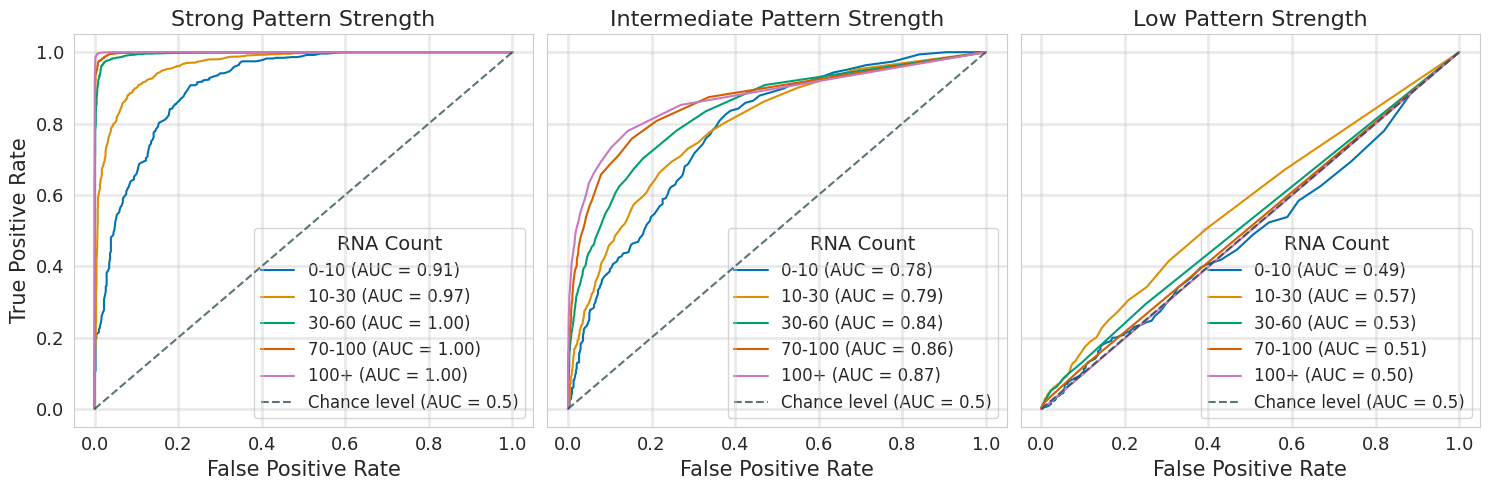

In [22]:
intervals = ['0-10','10-30','30-60', '70-100','100+']
predictions = {}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, strength in enumerate(['strong', 'intermediate', 'low']):
    ax = axs[i]  # Select the subplot for the current strength
    adata_strength = adatas[strength]
    for interval in intervals:
        adata_counts = adata_strength[adata_strength.obs['rna_count']==interval]
        test_pred = rf_pericellular.predict_proba(adata_counts.obsm["latent"])[:,1]
        predictions[interval] = RocCurveDisplay.from_predictions(
            adata_counts.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = interval,
            ax=ax,
            plot_chance_level=True if interval == '100+' else False,
            chance_level_kw={'color': '#143C40', 'alpha': 0.7})
    ax.set_xlabel("False Positive Rate",fontsize=15)
    ax.set_title(f"{strength.capitalize()} Pattern Strength",fontsize=16)
    ax.grid(True,linewidth=2)
    if i != 0:  # Remove the x-label for the non-left plots
        ax.set(ylabel="")
        ax.set_yticklabels([])
    else:  # Set the x-label for the left-most plot
        ax.set_ylabel("True Positive Rate", fontsize=15)
    #ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), label='Chance Level')  # Plot the chance level line
    
    ax.tick_params(axis='both', which='major', labelsize=13)  # Increase font size for ticks
    
    legend = ax.legend(title="RNA Count", loc='lower right', fontsize=12)  # Increase font size for legend text
    legend.get_title().set_fontsize(14)  # Increase font size for legend title
    legend.set_zorder(0)



plt.tight_layout(w_pad=1)
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

# Power Analysis Figure

### Load data from txt file

In [65]:
df = pd.read_csv('results.txt', sep='\t', names=['strength', 'rna_count', 'sample_size', 'power'])

In [66]:
df = df[df['strength']!='low 10-30   753 0.867']
new_row = pd.DataFrame({'strength': ['low'], 'rna_count': ['10-30'], 'sample_size': [753], 'power': [0.867]})
df = pd.concat([df, new_row], ignore_index=True)

### Load data from pickled dictionary

In [72]:
path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/power_analysis/power_analysis_allStrength_withoutReplacement_to7000_logscale_bonferroniCorrected.pkl"

with open(path, 'rb') as p:
    power_results = pickle.load(p)

In [73]:
# Convert the dictionary to a list of tuples
data = [(strength, rna_count, sample_size, power) for key, power in power_results.items() for strength, rna_count, sample_size in [key.split('_')]]

# Convert the list of tuples to a DataFrame
df = pd.DataFrame(data, columns=["strength", "rna_count", "sample_size", "power"])

### Preprocessing

In [74]:
df = df[df['power'] != -1].copy()
df['sample_size'] = df['sample_size'].astype(int)
df.loc[:,'strength'] = df['strength'].str.capitalize()
df['strength'].unique()

array(['Strong', 'Intermediate', 'Low'], dtype=object)

In [75]:
df['sample_size']

0         5
1         9
2        15
3        27
4        46
       ... 
205     753
206    1315
207    2297
208    4009
209    7000
Name: sample_size, Length: 198, dtype: int64

### Visualization

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/media/gambino/st

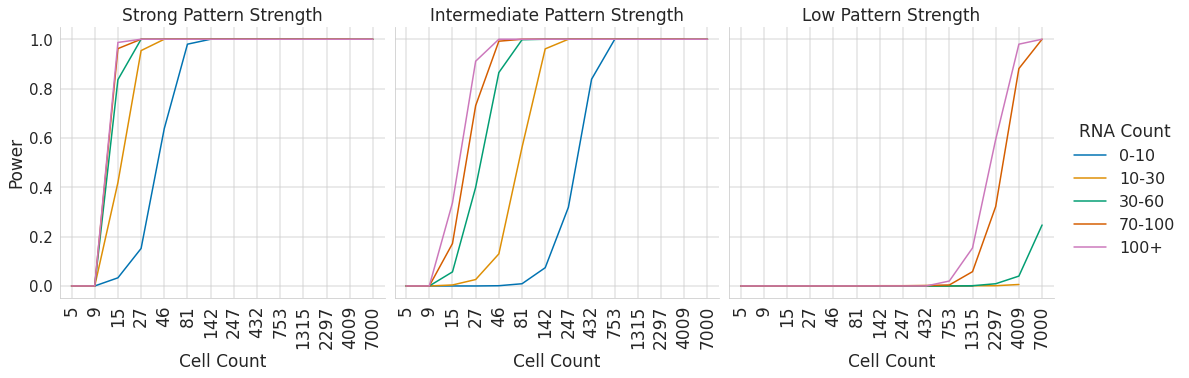

In [76]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
unique_sample_sizes = sorted(df['sample_size'].unique())
df.loc[:,'sample_size_index'] = df['sample_size'].apply(lambda x: unique_sample_sizes.index(x))

# Create three plots with different pattern strengths
g = sns.relplot(
    data=df, 
    x="sample_size_index", 
    y="power", 
    hue="rna_count",
    hue_order = ['0-10', '10-30', '30-60', '70-100','100+'],
    palette="colorblind",
    col="strength",
    kind="line"
)
g.set_axis_labels("Cell Count", "Power")
g.set_titles("{col_name} Pattern Strength")
g.tight_layout(w_pad=1)
g.legend.set_title("RNA Count")

# Set global font size parameters
plt.rc('axes', titlesize=17)     # Font size for titles
plt.rc('axes', labelsize=17)     # Font size for x and y labels
plt.rc('xtick', labelsize=17)    # Font size for x tick labels
plt.rc('ytick', labelsize=15)    # Font size for y tick labels
plt.rc('legend', fontsize=16)    # Font size for legend
plt.rc('legend', title_fontsize=17)    # Font size for legend title

# Function to set custom x-scale
def set_custom_xscale(ax, unique_vals):
    ax.set_xticks(range(len(unique_vals)))
    ax.set_xticklabels(unique_vals, rotation=90)
    ax.set_xlim(-0.5, len(unique_vals) - 0.5)
    ax.grid(True, linewidth=2)

# Rotate x-axis labels for each subplot
for ax in g.axes.flatten():
    set_custom_xscale(ax, unique_sample_sizes)
    
# Show the plot
plt.show()

## Figure 15

In [ ]:
strength = 'intermediate'
count = '0-10'
sample = 300

peri_gene = create_simulated_gene(adata_test_allstrengths, pattern = 'pericellular', mixed_patterns = False, pattern_strength = strength, rna_count = count, sample_size = sample, random_seed = True)
mixed_gene = create_simulated_gene(adata_test_allstrengths[adata_test_allstrengths.obs['pattern']!='pericellular'], mixed_patterns = True, pattern_strength = strength, rna_count = count, sample_size = sample, random_seed = True)
random_gene = create_simulated_gene(adata_test_allstrengths, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample, random_seed = True)

rows = []
for model in [rf_peri_unbalanced, rf_peri_balanced, rf_peri_balanced_inclRandom]:
    test = model.predict_proba(peri_gene.obsm["latent"])[:,1]
    other_pattern = model.predict_proba(mixed_gene.obsm["latent"])[:,1]
    random = model.predict_proba(random_gene.obsm["latent"])[:,1]
    for value in test:
        rows.append({'prob_pattern': value, 'group': 'pericellular', 'model': model})
    for value in other_pattern:
        rows.append({'prob_pattern': value, 'group': 'other_pattern', 'model': model})
    for value in random:
        rows.append({'prob_pattern': value, 'group': 'random', 'model': model})
df = pd.DataFrame(rows)

In [ ]:
pattern = 'pericellular'
model = rf_peri_balanced_inclRandom
pericellular = df[(df['group']=='pericellular')& (df['model']==model)]
other_pattern = df[(df['group']=='other_pattern') & (df['model']==model)]
random_gene = df[(df['group']=='random') & (df['model']==model)]

print(len(pericellular['prob_pattern'].unique()))
print(len(other_pattern['prob_pattern'].unique()))
print(len(random_gene['prob_pattern'].unique()))

plt.hist(random_gene['prob_pattern'], bins=37, alpha=0.7, label='No Pattern', density=True, color=colorblind_palette[0])
plt.hist(other_pattern['prob_pattern'], bins=50, alpha=0.6, label='Other Patterns', density=True, color=colorblind_palette[4])
plt.hist(pericellular['prob_pattern'], bins=55, alpha=0.5, label='Pericellular', density=True, color=colorblind_palette[2])


# Get the handles and labels from the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Sort them together based on the labels
order = [2, 1, 0]  # The order you want
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]

# Set the legend again with the sorted handles and labels
plt.legend(handles, labels, title = 'Simulated gene', loc='upper right')

plt.xlabel("RF probability score for Pericellular (versus other patterns)")
plt.ylabel("Relative frequency")
plt.title("Balanced RF Probability Curve, trained incl. random")
plt.show()